<a href="https://colab.research.google.com/github/ahlem-Ing/ahlem-Ing/blob/main/ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Intelligent Chat using Gemini By Google 🔥

In [1]:
#for the chat conversation
!pip install -q -U google-generativeai

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#for the sentence similarities
!pip install sentence-transformers

In [4]:
# for the wweb scraping
!pip install selenium
!apt update
!apt install chromium-chromedriver

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
61 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as 

In [5]:
!pip install translators

In [6]:
!pip install lingua-language-detector


In [7]:
# Import Libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from sentence_transformers import SentenceTransformer, util
import torch
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import time
from PIL import Image
import csv
import pandas as pd
import re
import os
import requests
import translators as ts


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [8]:
#Configure Chrome Options
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
dr = webdriver.Chrome(options=options)

In [9]:
import pathlib
import textwrap
import torch
import numpy as np
import google.generativeai as genai
import tensorflow as tf
import tensorflow_hub as hub

from IPython.display import display
from IPython.display import Markdown

from sentence_transformers import SentenceTransformer, util

import string


In [10]:
# Used to securely store your API key
from google.colab import userdata

In [11]:
# Or use `os.getenv('GOOGLE_API_KEY')` to fetch an environment variable.
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

# Intelligent ChatBot

In [35]:
# Building the AI
class ChatBot():
    def __init__(self, name):
        print("----- Starting up", name, "-----")
        self.chat = genai.GenerativeModel('gemini-pro')
        self.name = name
        self.messages=[]
        self.res=[]
        self.faqs=[]
        self.ques=[]
        self.dr = webdriver.Chrome(options=options)
        self.sim = SentenceTransformer('all-MiniLM-L6-v2')
        self.web_scraping()
        self.en_faqs=self.sim.encode(self.ques)
        self.embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
        self.loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/PFE (1)/AI/Models/domain_classifier")
        self.common_greetings = ["hi", "hello", "hey", "good morning", "good afternoon", "good evening", "howdy"]
#========================================================================================================================================
    def similar(self,user_input):
        en= self.sim.encode(user_input)
        result = util.cos_sim(en, self.en_faqs)
        indices=torch.nonzero(result > 0.7).squeeze()
        if len(indices)>0:
          # Find the index of the maximum value among elements greater than 0.5
          max_index = (torch.argmax(result)).item()
          # Return the response corresponding to the maximum value
          return self.res[max_index]
        else:
          return None

#========================================================================================================================================
    def get_faqs(self):
      xpath = "//div[@class='MuiAccordionSummary-expandIconWrapper css-yw020d-MuiAccordionSummary-expandIconWrapper']"
      element = WebDriverWait(self.dr, 10).until(
                EC.presence_of_element_located((By.XPATH, xpath))
            )
      element.click()
      time.sleep(2)

      page_html = self.dr.page_source
      # parsing the target web page with Beautiful Soup
      soup = BeautifulSoup(page_html, 'html.parser')
      FAQs_section= soup.find_all('div', class_='MuiBox-root css-8atqhb')
      for tag_element in FAQs_section:
            FAQs_elements = tag_element.find_all('div', class_='MuiAccordionDetails-root css-1dys5nb-MuiAccordionDetails-root')
            questions_elements=tag_element.find_all('p', class_='MuiTypography-root MuiTypography-body1 css-1276we6-MuiTypography-root')

            for FAQ in FAQs_elements :
              anchor_tag = FAQ.find('a')
              if anchor_tag:
                # Get the URL from the href attribute
                url = anchor_tag['href']
                # Replace the entire anchor tag with its URL
                anchor_tag.replace_with(url)
              chunks = [FAQ.text[i:i+500] for i in range(0, len(FAQ.text), 500)]
              translated_chunks = [ts.translate_text(chunk, translator="bing", from_language="fr",to_language="en") for chunk in chunks]
              translated_text = ''.join(translated_chunks) # Join the translated chunks
              self.res.append(translated_text)
            for qu in questions_elements :
              translated_text=ts.translate_text(qu.text, translator="bing", from_language="fr",to_language="en")
              self.ques.append(translated_text)

      for i in range(0,len(self.ques)):
            self.faqs.append(
                  {
                      'question': self.ques[i],
                      'Answer': self.res[i],
                  }
              )


#========================================================================================================================================
    def web_scraping(self):
      # Import the website for Scraping
      self.dr.get("https://ppms-sultan-dev.azurewebsites.net/besoin-daide/")
      time.sleep(2)
      self.get_faqs()
      xpath = "//button[@id='vertical-tab-1']"
      element = self.dr.find_element(By.XPATH, xpath)
      element.click()
      time.sleep(2)
      self.get_faqs()
      xpath = "//button[@id='vertical-tab-2']"
      element = self.dr.find_element(By.XPATH, xpath)
      element.click()
      time.sleep(2)
      self.get_faqs()

#========================================================================================================================================
    def domain(self,sentence):
      sentence_embedding = self.embed([sentence])
      prediction= np.argmax(self.loaded_model.predict(sentence_embedding))
      return prediction


#========================================================================================================================================
    def get_effia(self):
      # Import the website for Scraping

      self.dr.get("https://ppms-sultan-dev.azurewebsites.net/besoin-daide/souscrivez-un-abonnement")
      time.sleep(2)
      html_page=self.dr.page_source
      print("----- Scraping Done -----")
      print(html_page)
      return html_page

----- Starting up dev -----
----- Scraping Done -----
<html lang="en" translate="no"><head>
  <!-- Google tag (gtag.js) -->
  <script async="" src="https://www.googletagmanager.com/gtag/js?id=G-BCS00E0STK"></script>
  <script>
    window.dataLayer = window.dataLayer || [];
    function gtag(){dataLayer.push(arguments);}
    gtag('js', new Date());
// change personal key GA4 later
    gtag('config', 'G-BCS00E0STK');
  </script>
  <meta charset="utf-8">
  <link rel="icon" href="/Effia.png">
  <meta name="viewport" content="width=device-width, initial-scale=1">

  <meta name="theme-color" content="#000000">
  <meta name="description" content="Effia.be : Votre Solution de Stationnement de Confiance en Belgique

  Effia.be propose des solutions pratiques de stationnement pour les entreprises et les municipalités à travers la Belgique. Notre plateforme conviviale offre des expériences de stationnement sans tracas, permettant aux utilisateurs de trouver et de payer facilement leur stationneme
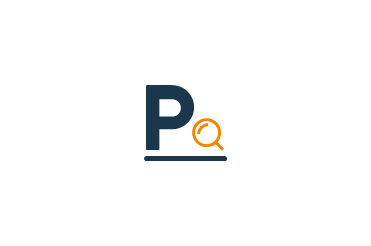
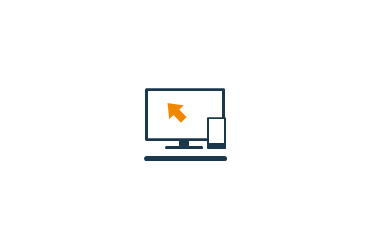
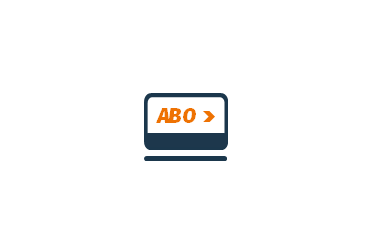
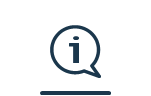
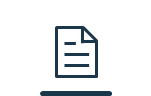
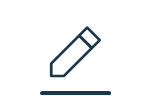
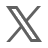

'<html lang="en" translate="no"><head>\n  <!-- Google tag (gtag.js) -->\n  <script async="" src="https://www.googletagmanager.com/gtag/js?id=G-BCS00E0STK"></script>\n  <script>\n    window.dataLayer = window.dataLayer || [];\n    function gtag(){dataLayer.push(arguments);}\n    gtag(\'js\', new Date());\n// change personal key GA4 later\n    gtag(\'config\', \'G-BCS00E0STK\');\n  </script>\n  <meta charset="utf-8">\n  <link rel="icon" href="/Effia.png">\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n\n  <meta name="theme-color" content="#000000">\n  <meta name="description" content="Effia.be : Votre Solution de Stationnement de Confiance en Belgique\n\n  Effia.be propose des solutions pratiques de stationnement pour les entreprises et les municipalités à travers la Belgique. Notre plateforme conviviale offre des expériences de stationnement sans tracas, permettant aux utilisateurs de trouver et de payer facilement leur stationnement via notre platforme. Avec n
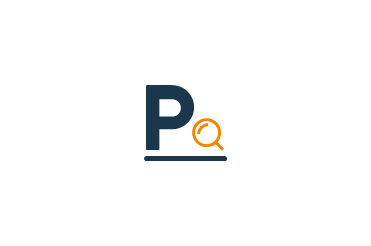
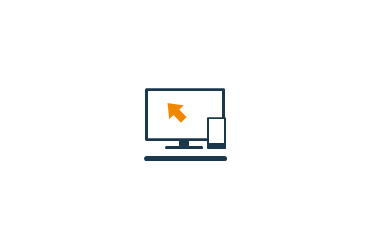
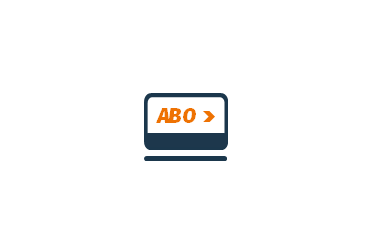
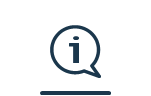
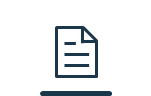
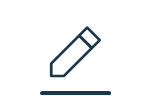
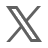

In [36]:
ai = ChatBot(name="dev")
ai.get_effia()

In [29]:

from lingua import Language, LanguageDetectorBuilder

# Define the languages you want to detect
languages = [Language.ENGLISH, Language.FRENCH, Language.SPANISH]

# Create a language detector for the specified languages
detector = LanguageDetectorBuilder.from_languages(*languages).build()
# Running the AI
if __name__ == "__main__":
    ai = ChatBot(name="dev")
    ex=True
    print("Chat: >> Hello I am Dave the AI, what can I do for you?")
    while ex:
        ## exit
        user_input = input("User: >> ")
        # Remove punctuation
        language = detector.detect_language_of(user_input).iso_code_639_1.name.lower()
        if language != 'en':
                user_input=ts.translate_text(user_input, translator="bing", from_language=language,to_language="en")
       # Remove punctuation
        words= ""
        for char in user_input:
            if char not in string.punctuation:
                words += char
        nb_words = len(words.split())
        words=words.lower().split()

        if(nb_words<3):
            if any(i in words for i in ["exit","close"]):
                    print("exit")
                    res = np.random.choice(["Tata","Have a good day","Bye","Goodbye","Hope to meet soon","peace out!"])
                    print("Chat: >> "+ res)
                    ex=False
            elif any(i in words for i in ["hello","hi","good morning","morning","good evening","evening","hola","what's up","hey","greetings"]):
                    ai.messages.append(
                                  {'role':'user',
                                  'parts': [user_input]}
                              )
                    response = ai.chat.generate_content(ai.messages)
                    ai.messages.append({'role':'model',
                                              'parts':[response.text]})
                    if language!= 'en':
                            chunks = [response.text[i:i+500] for i in range(0, len(response.text), 500)]
                            translated_chunks = [ts.translate_text(chunk, translator="bing", from_language="en",to_language=language) for chunk in chunks]
                            response = ''.join(translated_chunks) # Join the translated chunks
                            print("Chat: >> "+ response)
                    else:
                        print("Chat: >> "+ response.text)
            else:
                print("Chat: >> "+ "I'm sorry, but I didn't quite understand your request. Could you please clarify or rephrase your question? That will help me assist you better! ")
        else:
              response=ai.similar(user_input)
              if response is not None:
                if language!= 'en':
                    response=ts.translate_text(response, translator="bing", from_language="en",to_language=language)
                    print("Chat: >> "+ response)
                else:
                    print("Chat: >> "+ response)
                ## conversation
              else:
                  if(ai.domain(user_input)==1):
                      ai.messages.append(
                                {'role':'user',
                                'parts': [user_input]}
                            )
                      response = ai.chat.generate_content(ai.messages)
                      print(response.text)
                      ai.messages.append({'role':'model',
                                            'parts':[response.text]})

                      if language!= 'en':
                        # Split the response into smaller chunks for translation
                        chunks = [response.text[i:i+500] for i in range(0, len(response.text), 500)]
                        translated_chunks = [ts.translate_text(chunk, translator="bing", from_language="en",to_language=language) for chunk in chunks]
                        response = ''.join(translated_chunks) # Join the translated chunks
                        print("Chat: >> "+ response)
                      else:
                          print("Chat: >> "+ response.text)
                  else:
                      print("Chat: >> "+ "Apologies, but I can only assist with inquiries related to the transportation domain. Please let me know if you have a transportation-related question!")


    print("----- Closing down Dev -----")

----- Starting up dev -----
Chat: >> Hello I am Dave the AI, what can I do for you?
User: >> hello
Chat: >> Hola. ¿Cómo puedo ayudarle hoy?
User: >> hi
Chat: >> Hello! Is there anything I can help you with today?
User: >> bonjour
Chat: >> Salut! 👋 Comment puis-je vous aider aujourd’hui ?
User: >> how to subscribe ?
Chat: >> Do not hesitate to consult our website www.effia.be as places become available regularly. Another option, look at another profile.
User: >> close
exit
Chat: >> Hope to meet soon
----- Closing down Dev -----


# Testing

* note 01: vehicule LGP # vehicule GPL

In [14]:
if any(i in "LGP vehicule".lower() for i in ["hello","hi","good morning","morning","good evening","evening","hola","what's up","hey","greetings"]):
                    print("greeting")

greeting


In [15]:
#Are LPG vehicles allowed?
ts.translate_text("Are LPG vehicles allowed?", translator="bing", from_language="en",to_language="fr")


'Les véhicules GPL sont-ils autorisés ?'

In [16]:
user_input=ts.translate_text("abonnement velo et moto", translator="bing", from_language="fr",to_language="en")
print("similar:")
print(ai.similar("Are LPG vehicles allowed?"))

similar:
No


In [17]:

# Sample string
my_string = "Hello! How are you? I'm doing well, thanks."

# Remove punctuation
new_string = ""
for char in my_string:
    if char not in string.punctuation:
        new_string += char

# Output
print(new_string)

Hello How are you Im doing well thanks


In [18]:
!pip install langdetect

In [19]:
!pip install googletrans==4.0.0-rc1

In [20]:
from langdetect import detect

# Example user input
user_input = "bonjour"  # Example input in French

# Detect the language of the input
language = detect(user_input)
print(language)
from googletrans import Translator
translator = Translator()
language = translator.detect(user_input).lang
print(language)

hr
en


In [21]:
from lingua import Language, LanguageDetectorBuilder

# Define the languages you want to detect
languages = [Language.ENGLISH, Language.FRENCH, Language.SPANISH]

# Create a language detector for the specified languages
detector = LanguageDetectorBuilder.from_languages(*languages).build()

# The text to detect the language of
text = "HI!"

# Detect the language of the text
detected_language = detector.detect_language_of(text)

# Print the detected language
if detected_language:
    print(f"The detected language is: {detected_language.iso_code_639_1.name.lower()}")
else:
    print("Could not detect the language.")


The detected language is: en


In [22]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch

# Load pre-trained RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForQuestionAnswering.from_pretrained('roberta-base')

# Encode inputs
question = "activation of the subscription"
passage = '''In this article, you have learned how to solve two language challenges when you have text data with different languages and you want to translate the data into the single language of your choice
.Here's the translation of the provided French text into English:

---

**If the parking facility is equipped with a license plate recognition system, the subscription will be active on the day of payment.**

**If the parking facility is not equipped with a license plate recognition system, the subscription will be active 7 calendar days after payment.**I have created a simple python function that you can do both detect and translate the text into the language of your choice.'''

inputs = tokenizer.encode_plus(question, passage, return_tensors='pt')

# Perform forward pass
with torch.no_grad():
    outputs = model(**inputs)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

# Get the most likely start and end tokens
start_index = torch.argmax(start_scores).item()
end_index = torch.argmax(end_scores).item()
print(start_index)
print(end_index)
print(inputs['input_ids'][0])


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8
107
tensor([    0, 45888,     9,     5,  6656,     2,     2,  1121,    42,  1566,
            6,    47,    33,  2435,   141,     7,  6136,    80,  2777,  2019,
           77,    47,    33,  2788,   414,    19,   430, 11991,     8,    47,
          236,     7, 14620,     5,   414,    88,     5,   881,  2777,     9,
          110,  2031, 50118,     4, 11773,    18,     5, 19850,     9,     5,
         1286,  1515,  2788,    88,  2370,    35, 50118, 50118, 24965, 50118,
        50118, 12606,  1106,     5,  2932,  2122,    16,  8895,    19,    10,
         4385,  5299,  4972,   467,     6,     5,  6656,    40,    28,  2171,
           15,     5,   183,     9,  3207,     4, 12606, 50118, 50118, 12606,
         1106,     5,  2932,  2122,    16,    45,  8895,    19,    10,  4385,
         5299,  4972,   467,     6,     5,  6656,    40,    28,  2171,   262,
         7127,   360,    71,  3207,     4, 12606,   100,    33,  1412,    10,
         2007, 39825,  5043,    14,    47,    64,   109,  

In [23]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load pre-trained T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

# Prepare inputs
question = "activation of the subscription"
passage = '''In this article, you have learned how to solve two language challenges when you have text data with different languages and you want to translate the data into the single language of your choice
.Here's the translation of the provided French text into English:

---

**If the parking facility is equipped with a license plate recognition system, the subscription will be active on the day of payment.**

**If the parking facility is not equipped with a license plate recognition system, the subscription will be active 7 calendar days after payment.**I have created a simple python function that you can do both detect and translate the text into the language of your choice.'''
input_text = f"question: {question} context: {passage}"
inputs = tokenizer.encode(input_text, return_tensors='pt')

# Perform forward pass
with torch.no_grad():
    outputs = model.generate(inputs)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Answer: {answer}")


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Answer: the subscription will be active on the day of payment.** **If the parking facility is not


In [73]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options



#Configure Chrome Options
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(options=options)

driver.get("https://ppms-sultan-dev.azurewebsites.net/besoin-daide/souscrivez-un-abonnement")

# Wait for a specific element to be present
try:
  # class="MuiBox-root css-n4tm3x"
    xpath="//div[@class='MuiBox-root css-n4tm3x']"
    element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, xpath))  # Replace with a suitable condition
    )
finally:
    html_page = driver.page_source
    soup = BeautifulSoup(html_page, 'html.parser')
    divs=soup.find_all('p')
    for div in divs:  # Iterate over the divs
        print(div.text) # Print the text of each div
    driver.quit()


Souscrivez un abonnement

Choisissez votre parking 
renseignez votre période de stationnement. 
Sélectionnez une formule 
selon vos besoins. 
Envoyez votre demande 
en ligne en quelques clics seulement. 
Les informations essentielles pour une souscription :La durée d'engagement minimum d'un abonnement est de un mois (tacitement reconductible). Si vous bénéficiez d'une tarification spécifique (Etudiant, riverain ou travailleur à temps partiel), des pièces justificatives complémentaires vous seront demandées. Une confirmation d'abonnement sera envoyée par courriel reprenant toutes les informations utiles dès que le Service client aura traité votre demande. Cette confirmation d'abonnement vous permettra de connaître les procédures d'accès au parking.
Des offres flexibles
Des formules d'abonnements pour répondre à tous vos besoins sont disponibles dans nos parkings. Ces offres sont présentées à titre indicatif. D'autres formules sont également disponibles en fonction du parking sélectionné

In [54]:
content=""
for div in divs:  # Iterate over the divs
    content+=div.text

print(content)

Souscrivez un abonnementChoisissez votre parking renseignez votre période de stationnement. Sélectionnez une formule selon vos besoins. Envoyez votre demande en ligne en quelques clics seulement. Les informations essentielles pour une souscription :La durée d'engagement minimum d'un abonnement est de un mois (tacitement reconductible). Si vous bénéficiez d'une tarification spécifique (Etudiant, riverain ou travailleur à temps partiel), des pièces justificatives complémentaires vous seront demandées. Une confirmation d'abonnement sera envoyée par courriel reprenant toutes les informations utiles dès que le Service client aura traité votre demande. Cette confirmation d'abonnement vous permettra de connaître les procédures d'accès au parking.Des offres flexiblesDes formules d'abonnements pour répondre à tous vos besoins sont disponibles dans nos parkings. Ces offres sont présentées à titre indicatif. D'autres formules sont également disponibles en fonction du parking sélectionné.7J/7 • 24

In [59]:
from transformers import RobertaTokenizer, RobertaForQuestionAnswering
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load pre-trained T5 tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model= T5ForConditionalGeneration.from_pretrained('t5-small')


# Load pre-trained RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model= RobertaForQuestionAnswering.from_pretrained('roberta-base')


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
question = "combien la taarification d'un abonnement ?"
passage = content

In [69]:
# t5 _ multimodel

input_text = f"question: {question} context: {passage}"

inputs = t5_tokenizer.encode(input_text, return_tensors='pt')

# Perform forward pass
with torch.no_grad():
    outputs = t5_model.generate(inputs)
    t5_answer = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Answer: {t5_answer}")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Answer: Etudiant, riverain or travailleur à temps partiel


In [70]:
# Riberta _ multi modal

inputs = roberta_tokenizer.encode_plus(question, passage, return_tensors='pt')

with torch.no_grad():
    outputs = roberta_model(**inputs)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

# Get the most likely start and end tokens
start_index = torch.argmax(start_scores).item()
end_index = torch.argmax(end_scores).item()
roberta_answer = tokenizer.decode(inputs['input_ids'][0][start_index:end_index], skip_special_tokens=True)
print(f"Answer: {roberta_answer}")

Answer:  votre parking renseignez votre période de stationnement. Sélectionnez une formule selon vos besoins. Envoyez votre demande


In [72]:
import difflib

# Define the two answers
answer1 = "La durée d'engagement minimum d'un abonnement est de un mois (t"
answer2 = "La durée d'engagement minimum d'un abonnement est de un mois (tacitement reconductible)."

# Find the longest common substring
matcher = difflib.SequenceMatcher(None, answer1, answer2)
common_substring = ''
for match in matcher.get_matching_blocks():
    common_substring += answer1[match.a: match.a + match.size]

print("Common substring:", common_substring.strip())


Common substring: La durée d'engagement minimum d'un abonnement est de un mois (t
